In [8]:
import os
import numpy as np
#import mne
import glob
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
#import pypfopt
#import sklearn
#import covar
#import scipy as sp
#import seaborn as sns

from mpl_toolkits import mplot3d
from scipy import stats, signal
#from pypfopt.risk_models import risk_matrix
#from sklearn.covariance import LedoitWolf
#from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,corrmap)
from numpy import savetxt
from numpy.polynomial.polynomial import polyfit
from datetime import datetime
from scipy.optimize import curve_fit
from numpy import random

camcan_data_path = '/media/lcneuro/jvnbackup/camcan/'
id_gender_age_df = pd.read_csv(camcan_data_path + 'participants_edited.csv',delim_whitespace=True)

        

eeg_sub_ids = []
for direc in glob.iglob(camcan_data_path + 'sub-*/' + 'ses-rest/meg/' + 
                       'sub-*' + '.fif'):
    sub_id = re.sub('_ses-rest_task-rest_proc-sss.fif','',direc[58:])
    eeg_sub_ids.append(sub_id)
    
len(eeg_sub_ids)

# remove subjects from metadata that did not do MEG scanning
not_needed_df = id_gender_age_df[id_gender_age_df['ID'].isin(eeg_sub_ids)]
not_needed_list = not_needed_df['ID'].tolist()
id_gender_age_df = id_gender_age_df[id_gender_age_df['ID'].isin(not_needed_list)]

#print(not_needed_df)

# remove subjects that did not do blood test
#not_needed_df = id_gender_age_df[id_gender_age_df['ID'].isin(blood_data_ids)]
#not_needed_list = not_needed_df['ID'].tolist()
#id_gender_age_df = id_gender_age_df[id_gender_age_df['ID'].isin(not_needed_list)]



# sort metadata subject ID by data's subject ID order 
id_gender_age_df = id_gender_age_df.sort_values('ID')
id_gender_age_df = id_gender_age_df.reset_index(drop=True)

# i =0
# i = 198

print(id_gender_age_df)


In [11]:
id_gender_age_df = pd.read_csv('camcan_instability_magonly_nozeroes.csv')

#remove one person older than 87
id_gender_age_df = id_gender_age_df[id_gender_age_df['Age']<88]
#id_gender_age_df = id_gender_age_df.reset_index()

In [6]:
id_gender_age_df

,index,Unnamed: 0,ID,Age,hand,gender_text,gender_code,Average Instability,SD Instability
0,0,0,sub-CC110033,24,90.0,MALE,1,0.208677,0.031503
1,1,1,sub-CC110037,18,89.0,MALE,1,0.182746,0.014764
2,2,2,sub-CC110045,24,100.0,FEMALE,2,0.191046,0.010369
3,3,3,sub-CC110056,22,100.0,FEMALE,2,0.181932,0.017800
4,4,4,sub-CC110069,28,-58.0,FEMALE,2,0.153895,0.026972
...,...,...,...,...,...,...,...,...,...
625,626,626,sub-CC722536,79,-56.0,FEMALE,2,0.210986,0.030489
626,627,627,sub-CC722542,79,100.0,MALE,1,0.181781,0.029936
627,628,628,sub-CC722651,79,100.0,FEMALE,2,0.181003,0.025847
628,629,629,sub-CC722891,84,89.0,FEMALE,2,0.192735,0.010750


In [13]:
id_gender_age_df = id_gender_age_df[id_gender_age_df['Average Instability']>0]
#id_gender_age_df = id_gender_age_df.reset_index()

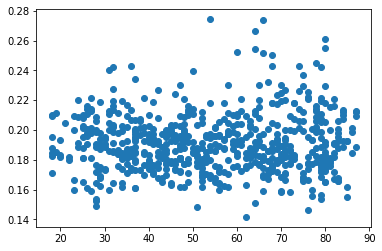

In [14]:
plt.figure()
plt.scatter(id_gender_age_df['Age'],id_gender_age_df['Average Instability'])

In [15]:
ages = np.unique(id_gender_age_df['Age'])
print(ages)

avg_instab_per_age = []
sem_instab_per_age = []

for i in range(0,len(ages)):
    temp = id_gender_age_df[id_gender_age_df['Age'] == ages[i]]
    #print(temp)
    #avg_instab_per_age.append(np.average(temp['avg_instab']))
    #sem_instab_per_age.append(sp.stats.sem(temp['avg_instab']))

[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]


In [17]:
bin_size=1

def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    

    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins


bins = create_bins(lower_bound=min(ages)-1,
                   width=bin_size,
                   quantity=int((max(ages)-min(ages))/bin_size))

bins2 = pd.IntervalIndex.from_tuples(bins)
#print(bins2)
categorical_object = pd.cut(id_gender_age_df['Age'], bins2)
categorical_object
#categorical_object.reset_index()

id_gender_age_df['Bin'] = categorical_object

In [18]:
id_gender_age_df

,Unnamed: 0,level_0,index,Unnamed: 0.1,ID,Age,hand,gender_text,gender_code,Average Instability,SD Instability,Bin
0,0,0,0,0,sub-CC110033,24,90.0,MALE,1,0.208677,0.031503,"(23, 24]"
1,1,1,1,1,sub-CC110037,18,89.0,MALE,1,0.182746,0.014764,"(17, 18]"
2,2,2,2,2,sub-CC110045,24,100.0,FEMALE,2,0.191046,0.010369,"(23, 24]"
3,3,3,3,3,sub-CC110056,22,100.0,FEMALE,2,0.181932,0.017800,"(21, 22]"
4,4,4,4,4,sub-CC110069,28,-58.0,FEMALE,2,0.153895,0.026972,"(27, 28]"
...,...,...,...,...,...,...,...,...,...,...,...,...
623,623,625,626,626,sub-CC722536,79,-56.0,FEMALE,2,0.210986,0.030489,"(78, 79]"
624,624,626,627,627,sub-CC722542,79,100.0,MALE,1,0.181781,0.029936,"(78, 79]"
625,625,627,628,628,sub-CC722651,79,100.0,FEMALE,2,0.181003,0.025847,"(78, 79]"
626,626,628,629,629,sub-CC722891,84,89.0,FEMALE,2,0.192735,0.010750,"(83, 84]"


In [16]:

avg_instabs = []
sem_instabs = []

for bin_num in bins2:
    #print(bin_num)
    instabs_bin = []
    for subj in range(len(id_gender_age_df)):
        if id_gender_age_df['Bin'][subj] == bin_num:
            instabs_bin.append(id_gender_age_df['Average Instability'][subj])
    #print(instabs_bin)
    avg = np.average(instabs_bin)
    sem = sp.stats.sem(instabs_bin)
    #print('avg=',avg)
    #print('sem=',sem)
    avg_instabs.append(avg)
    sem_instabs.append(sem)
    
bins_str = []
for i in range(len(bins)):
    string = '(' + str(bins[i][0]) + ',' + str(bins[i][1]) + ']'
    bins_str.append(string)
    
def sigmoid(x, x0, k, a, c):
    y = a / (1 + np.exp(-k*(x-x0))) + c
    return y

def line(x, m, b):
    y = (m*x) + b
    return y


xdata_label = bins_str
xdata = np.arange(1,len(bins_str)+1,1)
ydata = avg_instabs
noise = sem_instabs
# worked for bins of 10 years
#initial = (0.12,0.003,5.5,1)
initial_sigmoid = (len(xdata)*.6,.001,5.5,0)
initial_line = (0,0.19)
    


popt, pcov = curve_fit(sigmoid, xdata, ydata,sigma=noise,maxfev = int(10e+5),
                       absolute_sigma=True,p0=initial_sigmoid)
xfit_sig = np.arange(min(xdata),max(xdata)+.01,.01)
for i in range(0,len(xfit_sig)):
    xfit_sig[i] = round(xfit_sig[i],2)
yfit_sig = sigmoid(xfit_sig, *popt)
sig_ydata = []
for i in range(0,len(xfit_sig)):
    xfit_sig[i] = round(xfit_sig[i],2)
    if xfit_sig[i].is_integer() == True:
        sig_ydata.append(yfit_sig[i])
chi2_sig = []
for i in range(len(ydata)):
    chi2_sig.append(((ydata[i] - sig_ydata[i])/(noise[i]))**2)
chi2_sig = np.sum(chi2_sig)/(len(ydata)-4)
######

popt_line, pcov_line = curve_fit(line, xdata, ydata, sigma=noise, maxfev = int(10e+5),
                                absolute_sigma=True,p0=initial_line)
xfit_line = np.arange(min(xdata),max(xdata)+.01,.01)
for i in range(0,len(xfit_line)):
    xfit_line[i] = round(xfit_line[i],2)
yfit_line = line(xfit_line,*popt_line)
line_ydata=[]
for i in range(0,len(xfit_line)):
    xfit_line[i] = round(xfit_line[i],2)
    if xfit_line[i].is_integer() == True:
        line_ydata.append(yfit_line[i])
chi2_line = []
for i in range(len(ydata)):
    chi2_line.append(((ydata[i] - line_ydata[i])/(noise[i]))**2)
chi2_line = np.sum(chi2_line)/(len(ydata)-2)
#####
                     
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.errorbar(xdata,ydata,yerr=noise,fmt='o',capsize=3,color='black')


ax.set_xticks(xdata)
ax.set_xticklabels(bins_str, rotation='vertical',fontsize=12)
ax.tick_params(axis='y',labelsize=12)
#ax.plot(xfit_sig,yfit_sig,color='red',label='Sigmoid, chi2 = ' + str(round(chi2_sig,3)))
ax.plot(xfit_line,yfit_line,color='blue',label='Line, chi2 = ' + str(round(chi2_line,3)))

ax.set_xlabel('Age',size=20)
ax.set_ylabel('Instability',size=20)
ax.set_title('MEG Instability',size=25)
ax.legend()

fig = ax.get_figure()
#fig.savefig("instab_binned_5years.pdf")

#plt.figure(figsize=(10,5))
#plt.xlabel(bins_str)
#plt.errorbar(xdata,ydata,yerr=noise,fmt='o',capsize=3,color='black')
#plt.plot(xfit,yfit,color='red')

NameError: name 'sp' is not defined

<ErrorbarContainer object of 3 artists>

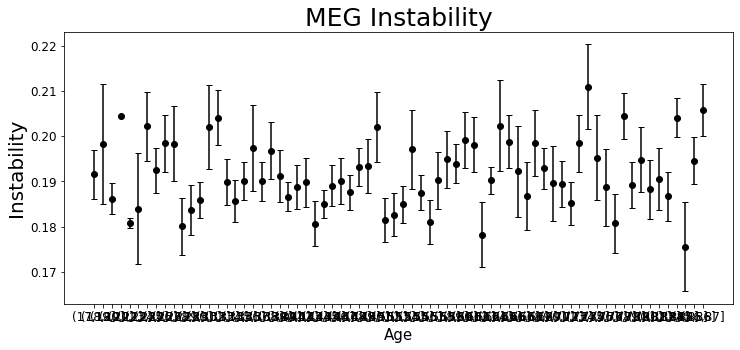

In [15]:
# scatter plot only

plt.figure(figsize=(12,5))
plt.title('MEG Instability',size=25)
plt.ylabel('Instability',size=20)
plt.xlabel('Age',size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.errorbar(bins_str,avg_instabs,yerr=sem_instabs,fmt='o',capsize=3,color='black')
#plt.savefig('instability_binned.pdf')